### WRN Deep ResNet
- Wide Residual Networks: https://arxiv.org/pdf/1605.07146.pdf
- Deep Residual Learning for Image Recognition: https://arxiv.org/pdf/1512.03385.pdf


=> input bx1x28x28
- -> Conv (out: bx64x28x28)
- -> maxpool (out: bx64x14x14)
- -> resnet block (out: bx128x14x14)
- -> resnet block (out: bx256x7x7)
- -> avgpool(1,1) (out: bx256x1x1)
- -> linear(256, 10) (out: bx10)

Using Dropout 0.18 in the resnet blocks instead of Batch norm

Also I introduced setting the LR to 0.2 (Big Steps) every x'th epoch in order to escape out of local minimas. It turned out to improve my test acc. by almost 1%

### Training using SGD with:
- Weight decay : 0.0001
- Momentum fixed : 0.9:

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# Any results you write to the current directory are saved as output.
import torch
from torch import nn
from torch.nn.parameter import Parameter
import torch.optim as optim
import torch.nn.functional as F
from matplotlib import pyplot as plt
import time
from PIL import Image

import torchvision
from torchvision import transforms

if torch.cuda.is_available():
    use_cuda=True
else:
    use_cuda=False

device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


# Data Loader

In [3]:
data_train = torchvision.datasets.FashionMNIST("data/FashionMNIST/resnet", train=True, transform=None, target_transform=None, download=True)
data_test = torchvision.datasets.FashionMNIST("data/FashionMNIST/resnet", train=False, transform=None, target_transform=None, download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/resnet\FashionMNIST\raw\train-images-idx3-ubyte.gz to data/FashionMNIST/resnet\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/resnet\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data/FashionMNIST/resnet\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/resnet\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data/FashionMNIST/resnet\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/resnet\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data/FashionMNIST/resnet\FashionMNIST\raw



d:\MBKM\Start up campus\Final Projeck\Fashion_Mnist\env\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
df_train = pd.DataFrame(np.hstack((data_train.train_labels.reshape(-1, 1), data_train.train_data.reshape(-1,28*28))))
df_test = pd.DataFrame(np.hstack((data_test.test_labels.reshape(-1, 1), data_test.test_data.reshape(-1,28*28))))
df_train.head()

d:\MBKM\Start up campus\Final Projeck\Fashion_Mnist\env\lib\site-packages\torchvision\datasets\mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
d:\MBKM\Start up campus\Final Projeck\Fashion_Mnist\env\lib\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
d:\MBKM\Start up campus\Final Projeck\Fashion_Mnist\env\lib\site-packages\torchvision\datasets\mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
d:\MBKM\Start up campus\Final Projeck\Fashion_Mnist\env\lib\site-packages\torchvision\datasets\mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,119,114,130,76,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,33,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
print(df_train.shape)
print(df_test.shape)

(60000, 785)
(10000, 785)


In [8]:
class_names = {
    0 : "T-shirt/top",
    1 : "Trouser",
    2 : "Pullover",
    3 : "Dress",
    4 : "Coat",
    5 : "Sandal",
    6 : "Shirt",
    7 : "Sneaker",
    8 : "Bag",
    9 : "Ankle boot"
}
class_names

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [19]:
# First column = classnames, and rest = image
df_train.iloc[:,0].value_counts()

9    6000
0    6000
3    6000
2    6000
7    6000
5    6000
1    6000
6    6000
4    6000
8    6000
Name: 0, dtype: int64

<AxesSubplot: >

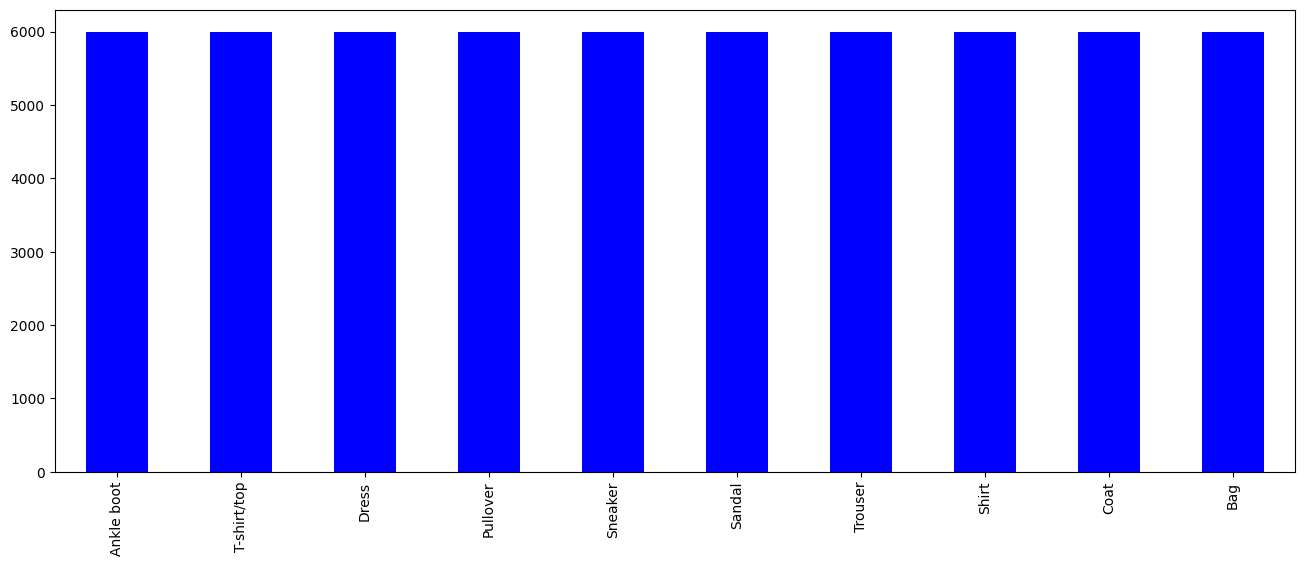

In [20]:
# plot a distribution data classnames
cnt_df=df_train.iloc[:,0].value_counts()
cnt_df.rename(class_names,axis=0).plot.bar(figsize=(16,6),color='b')

# Data Pipline Preprocessing
- Random horizontal flips
- Padding left/right 5px, top/bottom 6px
- Random cropping to 28x28 px
- Random square blackout region in img with hight, width being between: 28 x 0.15 <--> 28 x 0.60

In [29]:
min_side=np.min((28,28))
high = np.round(min_side * .60)
low = np.round(min_side * .15)
np.random.randint(high=high,low=low,size=(2))

array([14,  9])

In [30]:
def random_blackout(img, input_dim=(28,28)):
    min_side = np.min(input_dim)
    high = np.round(min_side * .60)
    low = np.round(min_side * .15)
    # height , width 
    height, width = np.random.randint(high=high,low=low,size=(2))
    # ofset top and left
    ofs_t = np.random.randint(high=input_dim[0]-height, low=0, size=1)[0]
    ofs_l = np.random.randint(high=input_dim[0]-width,low=0,size=1)[0]
    
    mask = np.ones(input_dim)
    mask[ofs_t ,:ofs_t + height ,ofs_l + width] = 0
    return img * mask

In [31]:
class BlackoutTransform():
    def __init__(self):
        """
        """
    def __call__(self,img):
        img_dim = img.shape
        np_arr = img.view(28,28).numpy()
        np_arr = random_blackout(np,np_arr.shape)
        return torch.FloatTensor(np_arr).view(img_dim)

In [ ]:
class ReshapeTransform():
    def __init__(self,new_size):
        """
        :new_size : tuple
        """
        self.new_size = new_size
    def __call__(self,img):
        